## Importing Libraries

In [1]:
# Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# Preprocessing libraries
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from sklearn.preprocessing import LabelEncoder

# TF libraries
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall

# Fine tuning libraries
import keras_tuner

## GPU set Memory Growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Importing Data

### Importing Labels

In [3]:
training_path = "./Dataset/Training"
training_labels = pd.read_csv(
    os.path.join(training_path,"training_labels.csv"),
    delimiter = ","
)

validation_path = "./Dataset/Validation"
validation_labels = pd.read_csv(
    os.path.join(validation_path,"validation_labels.csv"),
    delimiter = ","
)

testing_path = "./Dataset/Testing"
testing_labels = pd.read_csv(
    os.path.join(testing_path,"testing_labels.csv"),
    delimiter = ","
)

### Encoding Labels

In [4]:
encoder = LabelEncoder()

training_labels_enc = to_categorical(
    encoder.fit_transform(training_labels["MEDICINE_NAME"]),
    num_classes=78
)

validation_labels_enc = to_categorical(
    encoder.fit_transform(validation_labels["MEDICINE_NAME"]),
    num_classes=78
)

testing_labels_enc = to_categorical(
    encoder.fit_transform(testing_labels["MEDICINE_NAME"]),
    num_classes=78
)

### Importing Images

#### Config

In [ ]:
image_size = (600, 200) # Width, Height
padding_horizontal = 200
padding_vertical = 75
padding_color = (255, 0, 0)

batch_size = 32

#### Import Function

In [12]:
def get_images(path, labels_enc):
    images = []
    files = glob.glob(path + "/*png")
    for file in files:
        img = Image.open(file).convert("L")  # Convert to grayscale

        # Resize based on height only (preserve text width)
        w, h = img.size
        new_h = image_size[1]
        scale = new_h / h
        new_w = int(w * scale)
        img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Pad width if it's larger than target size
        if new_w > image_size[0]:
            pad_w = 0  # No padding needed
        else:
            pad_w = (image_size[0] - new_w) // 2
        
        # Expand image to match the target size
        img = ImageOps.expand(img, (pad_w, 0, image_size[0] - new_w - pad_w, 0), fill=255)

        # Apply AutoContrast
        img = ImageOps.autocontrast(img)

        # Denoise with Gaussian blur
        img = img.filter(ImageFilter.GaussianBlur(3))

        # Apply Binarization
        img = img.point(lambda p: 255 if p > 250 else 0)

        # Convert to Numpy array and normalize
        images.append(np.asarray(img).astype("float32") / 255.0)
    
    images = np.array(images)
    np_labels_enc = np.array(labels_enc)

    print(images.shape)

    # Create tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, np_labels_enc))
    dataset = dataset.batch(batch_size)

    return dataset

In [13]:
training_dataset = get_images(training_path + "/training_words", training_labels_enc)
validation_dataset = get_images(validation_path + "/validation_words", validation_labels_enc)
testing_dataset = get_images(testing_path + "/testing_words", testing_labels_enc)

# Shuffling Training Dataset
BUFFER_SIZE = 3120
training_dataset = training_dataset.shuffle(BUFFER_SIZE, seed = 42)

(3120, 200, 600)
(780, 200, 600)
(780, 200, 600)


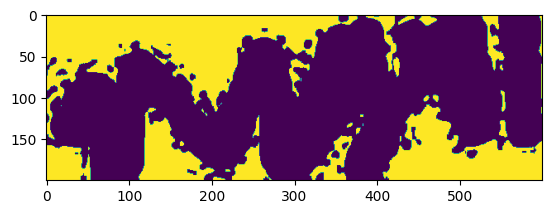

In [14]:
for images, labels in training_dataset.take(1):
    plt.imshow(images[0])

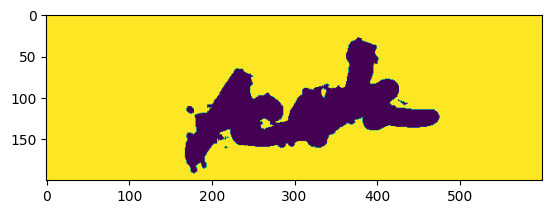

: 

In [ ]:
for images, labels in testing_dataset.take(1):
    plt.imshow(images[0])

## Creating Optimal Model

In [ ]:
metrics = [
        'accuracy', 
        Precision(name = 'precision'),
        Recall(name = 'recall'),
        # f1_score
    ]

model = Sequential([
    layers.Conv2D(32, kernel_size = 5, activation="relu", input_shape = (image_size[1], image_size[0], 1)),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(64, kernel_size = 5, activation="relu"),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(64, kernel_size = 3, activation="relu"),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),

    layers.Dense(256, activation="leaky_relu"),
    layers.Dense(512, activation="leaky_relu"),
    layers.Dense(78, activation = "softmax")
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

model.fit(
    training_dataset,
    epochs = 20,
    validation_data = validation_dataset,
    callbacks = [
        keras.callbacks.EarlyStopping("accuracy", mode="max", patience=3),
        keras.callbacks.EarlyStopping("val_recall", mode="max", patience=3),
        keras.callbacks.EarlyStopping("val_loss", mode="min", patience=3)
    ]
)

Epoch 1/20
101/195 [==============>...............] - ETA: 6s - loss: 4.3896 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

In [ ]:
model.evaluate(testing_dataset)

49/49 [==============================] - 1s 19ms/step - loss: 5.1906 - accuracy: 0.0026 - precision: 0.0000e+00 - recall: 0.0000e+00


[5.190562725067139, 0.0025641026441007853, 0.0, 0.0]